# Download Dataset

In [ ]:
! kaggle datasets download -d Cornell-University/movie-dialog-corpus

 56% 5.00M/8.91M [00:00<00:00, 32.3MB/s]
100% 8.91M/8.91M [00:00<00:00, 46.1MB/s]


In [ ]:
! unzip '/content/movie-dialog-corpus.zip'

Archive:  /content/movie-dialog-corpus.zip
  inflating: README.txt              
  inflating: movie_characters_metadata.tsv  
  inflating: movie_conversations.tsv  
  inflating: movie_lines.tsv         
  inflating: movie_titles_metadata.tsv  
  inflating: raw_script_urls.tsv     


#Imports

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import re
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Flatten , Embedding, Input, LSTM, Dropout
from tensorflow.keras.models import Model
from keras.initializers import Constant


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Preprocessing

In [ ]:
lines = open('/content/movie_lines.tsv', encoding='utf-8', errors='ignore').read().split('\n')
convos = open('/content/movie_conversations.tsv', encoding='utf-8', errors='ignore').read().split('\n')

In [ ]:
for i in convos[:5]:
  print(i,end='\n')

u0	u2	m0	['L194' 'L195' 'L196' 'L197']
u0	u2	m0	['L198' 'L199']
u0	u2	m0	['L200' 'L201' 'L202' 'L203']
u0	u2	m0	['L204' 'L205' 'L206']
u0	u2	m0	['L207' 'L208']


In [ ]:
for i in lines[:5]:
  print(i,end='\n')

L1045	u0	m0	BIANCA	They do not!
L1044	u2	m0	CAMERON	They do to!
L985	u0	m0	BIANCA	I hope so.
L984	u2	m0	CAMERON	She okay?
L925	u0	m0	BIANCA	Let's go.


In [ ]:
exchange = []

for conv in convos:
  exchange.append(conv.split('\t')[-1][1:-1].replace("'","").split(' '))    

In [ ]:
for i in exchange[:5]:
  print(i,end='\n')

['L194', 'L195', 'L196', 'L197']
['L198', 'L199']
['L200', 'L201', 'L202', 'L203']
['L204', 'L205', 'L206']
['L207', 'L208']


In [ ]:
dialogues = {}

for line in lines:
  temp = line.split('\t')
  dialogues[temp[0].replace('"','')] = temp[-1]

In [ ]:
import itertools
dict(itertools.islice(dialogues.items(), 5))

{'L1045': 'They do not!',
 'L1044': 'They do to!',
 'L985': 'I hope so.',
 'L984': 'She okay?',
 'L925': "Let's go."}

In [ ]:
del (conv, convos, i, line, lines, temp)

In [ ]:
questions = []
answers = []

for i in exchange:
  for j in range(len(i)-1):
    questions.append(dialogues[i[j]])
    answers.append(dialogues[i[j+1]])

In [ ]:
for i in range(10):
  print(f'{i+1}. {questions[i]} ----> {answers[i]}',end='\n\n')

1. Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again. ----> Well I thought we'd start with pronunciation if that's okay with you.

2. Well I thought we'd start with pronunciation if that's okay with you. ----> Not the hacking and gagging and spitting part.  Please.

3. Not the hacking and gagging and spitting part.  Please. ----> Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

4. You're asking me out.  That's so cute. What's your name again? ----> Forget it.

5. No no it's my fault -- we didn't have a proper introduction --- ----> Cameron.

6. Cameron. ----> The thing is Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.

7. The thing is Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does. ----> Seems like she could get a date easy enough...

8. Why? ----> Uns

In [ ]:
# keep only those questions and answers whose length is less than threshold

threshold = 75
filter_que = []
filter_ans = []

for i in range(len(questions)):
  if len(questions[i])<=threshold:
    if len(answers[i])<=threshold:
      filter_que.append(questions[i])
      filter_ans.append(answers[i])

In [ ]:
for i in range(10):
  print(f'{i+1}. {filter_que[i]} ----> {filter_ans[i]}',end='\n\n')

1. Well I thought we'd start with pronunciation if that's okay with you. ----> Not the hacking and gagging and spitting part.  Please.

2. Not the hacking and gagging and spitting part.  Please. ----> Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

3. You're asking me out.  That's so cute. What's your name again? ----> Forget it.

4. No no it's my fault -- we didn't have a proper introduction --- ----> Cameron.

5. Gosh if only we could find Kat a boyfriend... ----> Let me see what I can do.

6. C'esc ma tete. This is my head ----> Right.  See?  You're ready for the quiz.

7. That's because it's such a nice one. ----> Forget French.

8. How is our little Find the Wench A Date plan progressing? ----> Well there's someone I think might be --

9. There. ----> Where?

10. You have my word.  As a gentleman ----> You're sweet.



In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r" 'bout", " about", text)
  text = re.sub(r"gonna", "going to", text)
  text = re.sub(r"gotta", "got to", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub("\d+","",text) # remove numbers
  text = re.sub(r"[^\w\s]", "", text) # remove punctuations
  return text

In [ ]:
frame = [filter_que,filter_ans]
df = pd.DataFrame(frame, index=['questions', 'answers']).T

In [ ]:
print(df.shape)

(137344, 2)


In [ ]:
df.head()

,questions,answers
0,Well I thought we'd start with pronunciation i...,Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,No no it's my fault -- we didn't have a proper...,Cameron.
4,Gosh if only we could find Kat a boyfriend...,Let me see what I can do.


In [ ]:
df['questions'] = df['questions'].apply(clean_text)
df['answers'] = df['answers'].apply(clean_text)

In [ ]:
df.head()

,questions,answers
0,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how about we try out some french cui...
2,you are asking me out that is so cute what is...,forget it
3,no no it is my fault we did not have a proper...,cameron
4,gosh if only we could find kat a boyfriend,let me see what i can do


In [ ]:
# del (answers,dialogues,exchange,frame,questions,threshold,i,j)

In [ ]:
merge = pd.concat([df['questions'], df['answers']], axis = 0).drop_duplicates(keep='first')

In [ ]:
# create list of sentences in both columns to train word2vec. eg: [['i','am']['you','are']]

sentences=[]
for each in merge:
  sents = word_tokenize(each)
  sentences.append(sents)

print(len(sentences))

167286


In [ ]:
for i in sentences[:5]:
  print(f'{i}',end='\n\n')

['well', 'i', 'thought', 'we', 'would', 'start', 'with', 'pronunciation', 'if', 'that', 'is', 'okay', 'with', 'you']

['not', 'the', 'hacking', 'and', 'gagging', 'and', 'spitting', 'part', 'please']

['you', 'are', 'asking', 'me', 'out', 'that', 'is', 'so', 'cute', 'what', 'is', 'your', 'name', 'again']

['no', 'no', 'it', 'is', 'my', 'fault', 'we', 'did', 'not', 'have', 'a', 'proper', 'introduction']

['gosh', 'if', 'only', 'we', 'could', 'find', 'kat', 'a', 'boyfriend']



In [ ]:
# add <start> <end> in word2vec as well because its needed in decoder model

for i in range(100,150000,100):
  sentences[i].insert(0,"<START>")
  sentences[i].insert(len(sentences[i]),"<END>")

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(8201166, 12145730)

In [ ]:
w2v_model.wv.most_similar('she')

[('her', 0.5625358819961548),
 ('mother', 0.5089250802993774),
 ('he', 0.4928358793258667),
 ('girl', 0.48948782682418823),
 ('mom', 0.442224383354187),
 ('abated', 0.441238135099411),
 ('it', 0.43279749155044556),
 ('wife', 0.4303394854068756),
 ('woman', 0.42923516035079956),
 ('nobody', 0.42373526096343994)]

In [ ]:
vocab=w2v_model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  34469


In [ ]:
word_count = {}
for each in sentences:
  for i in each:
    if i not in word_count:
      word_count[i] = 1
    else:
      word_count[i] += 1

In [ ]:
# keep only those words whose frequency is greater than threshold

thresh = 3
vocab_dict={}

for word,count in word_count.items():
  if count >= thresh:
    vocab_dict[word] = w2v_model.wv.get_vector(word)

len(vocab_dict)

13014

In [ ]:
# add <out> for the words that are left out from vocab_dict

vocab_dict['<OUT>'] = np.zeros(300)
len(vocab_dict)

13015

In [ ]:
vocab = list(vocab_dict.keys())

In [ ]:
vocab_size = len(vocab)

In [ ]:
tok_questions = []

for each in df['questions']:
  sents = word_tokenize(each)
  tok_questions.append(sents)

In [ ]:
tok_answers = []

for each in df['answers']:
  sents = word_tokenize(each)
  tok_answers.append(sents)

In [ ]:
for each in tok_answers:
  each.insert(0,"<START>")
  each.insert(len(each),"<END>")

In [ ]:
for i in tok_questions[:5]:
  print(f'{i}',end='\n\n')
for i in tok_answers[:5]:
  print(f'{i}',end='\n\n')

['well', 'i', 'thought', 'we', 'would', 'start', 'with', 'pronunciation', 'if', 'that', 'is', 'okay', 'with', 'you']

['not', 'the', 'hacking', 'and', 'gagging', 'and', 'spitting', 'part', 'please']

['you', 'are', 'asking', 'me', 'out', 'that', 'is', 'so', 'cute', 'what', 'is', 'your', 'name', 'again']

['no', 'no', 'it', 'is', 'my', 'fault', 'we', 'did', 'not', 'have', 'a', 'proper', 'introduction']

['gosh', 'if', 'only', 'we', 'could', 'find', 'kat', 'a', 'boyfriend']

['<START>', 'not', 'the', 'hacking', 'and', 'gagging', 'and', 'spitting', 'part', 'please', '<END>']

['<START>', 'okay', 'then', 'how', 'about', 'we', 'try', 'out', 'some', 'french', 'cuisine', 'saturday', 'night', '<END>']

['<START>', 'forget', 'it', '<END>']

['<START>', 'cameron', '<END>']

['<START>', 'let', 'me', 'see', 'what', 'i', 'can', 'do', '<END>']



In [ ]:
one_hot_questions = []

for sentence in tok_questions:
  temp = []
  for each in sentence:
    if each in vocab:
      temp.append(vocab.index(each))
    else:
      temp.append(vocab.index('<OUT>'))
  one_hot_questions.append(temp)

In [ ]:
one_hot_answers = []

for sentence in tok_answers:
  temp = []
  for each in sentence:
    if each in vocab:
      temp.append(vocab.index(each))
    else:
      temp.append(vocab.index('<OUT>'))
  one_hot_answers.append(temp)

In [ ]:
for i in tok_questions[:5]:
  print(f'{i}',end='\n')
print()
for i in one_hot_questions[:5]:
  print(f'{i}',end='\n')

['well', 'i', 'thought', 'we', 'would', 'start', 'with', 'pronunciation', 'if', 'that', 'is', 'okay', 'with', 'you']
['not', 'the', 'hacking', 'and', 'gagging', 'and', 'spitting', 'part', 'please']
['you', 'are', 'asking', 'me', 'out', 'that', 'is', 'so', 'cute', 'what', 'is', 'your', 'name', 'again']
['no', 'no', 'it', 'is', 'my', 'fault', 'we', 'did', 'not', 'have', 'a', 'proper', 'introduction']
['gosh', 'if', 'only', 'we', 'could', 'find', 'kat', 'a', 'boyfriend']

[0, 1, 2, 3, 4, 5, 6, 13014, 7, 8, 9, 10, 6, 11]
[12, 13, 14, 15, 16, 15, 17, 18, 19]
[11, 20, 21, 22, 23, 8, 9, 24, 25, 26, 9, 27, 28, 29]
[30, 30, 31, 9, 32, 33, 3, 34, 12, 35, 36, 37, 38]
[39, 7, 40, 3, 41, 42, 43, 36, 44]


In [ ]:
for i in tok_answers[:5]:
  print(f'{i}',end='\n')
print()
for i in one_hot_answers[:5]:
  print(f'{i}',end='\n')

['<START>', 'not', 'the', 'hacking', 'and', 'gagging', 'and', 'spitting', 'part', 'please', '<END>']
['<START>', 'okay', 'then', 'how', 'about', 'we', 'try', 'out', 'some', 'french', 'cuisine', 'saturday', 'night', '<END>']
['<START>', 'forget', 'it', '<END>']
['<START>', 'cameron', '<END>']
['<START>', 'let', 'me', 'see', 'what', 'i', 'can', 'do', '<END>']

[255, 12, 13, 14, 15, 16, 15, 17, 18, 19, 256]
[255, 10, 78, 52, 134, 3, 638, 23, 491, 245, 11649, 124, 147, 256]
[255, 145, 31, 256]
[255, 291, 256]
[255, 179, 22, 217, 26, 1, 68, 83, 256]


In [ ]:
# # create one hot vector for each sentence. eg: [[32,34][12,54]]

# tok = Tokenizer()
# tok.fit_on_texts(sentences)
# one_hot = tok.texts_to_sequences(sentences)

In [ ]:
# find max length of sentences for padding

maxi=0
for i in one_hot_answers:
    if len(i)>maxi:
      maxi = len(i)
print(maxi)

23


In [ ]:
encoder_questions = pad_sequences(one_hot_questions, padding='post', maxlen=maxi)
encoder_answers = pad_sequences(one_hot_answers, padding='post', maxlen=maxi)

In [ ]:
decoder_answers = []

for each in encoder_answers:
  decoder_answers.append(each[1:])

decoder_answers = pad_sequences(decoder_answers, padding='post', maxlen=maxi)

In [ ]:
encoder_questions

array([[    0,     1,     2, ...,     0,     0,     0],
       [   12,    13,    14, ...,     0,     0,     0],
       [   11,    20,    21, ...,     0,     0,     0],
       ...,
       [ 1837, 13014,   353, ...,     0,     0,     0],
       [   27,  2264,  1298, ...,     0,     0,     0],
       [    1,    87,    81, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoder_answers

array([[  255,    12,    13, ...,     0,     0,     0],
       [  255,    10,    78, ...,     0,     0,     0],
       [  255,   145,    31, ...,     0,     0,     0],
       ...,
       [  255,    93,   493, ...,     0,     0,     0],
       [  255,     1,    87, ...,     0,     0,     0],
       [  255,  2623, 13014, ...,     0,     0,     0]], dtype=int32)

In [ ]:
decoder_answers

array([[   12,    13,    14, ...,     0,     0,     0],
       [   10,    78,    52, ...,     0,     0,     0],
       [  145,    31,   256, ...,     0,     0,     0],
       ...,
       [   93,   493,   574, ...,     0,     0,     0],
       [    1,    87,    81, ...,     0,     0,     0],
       [ 2623, 13014,  1020, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print(np.shape(encoder_questions))
print(np.shape(encoder_answers))
print(np.shape(decoder_answers))

(137344, 23)
(137344, 23)
(137344, 23)


In [ ]:
# create embedding matrix

embed_dim = 300
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for i,word in enumerate(vocab):
  embed_vector=vocab_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector

# Modelling

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check accuracy
    if(logs.get('acc') > 0.97):

      # Stop if threshold is met
      print("\nAccuracy is higher than 97% so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
# input of encoder and decoder
enc_inp = Input(shape=(maxi,))
dec_inp = Input(shape=(maxi,))

# this layer embeds the english word in vector form
embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxi, embeddings_initializer=Constant(embed_matrix))
enc_embed = embed(enc_inp)

# LSTM takes all the words at the same time but processes it one by one. The last _,_,_ is related to its previous state. So only final o/p is enough.
enc_lstm = LSTM(400, return_sequences=True, return_state=True)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c]

# embedding is done in decoding and the LSTM return a series of sequence
dec_embed = embed(dec_inp)
dec_lstm = LSTM(400, return_sequences=True, return_state=True)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

dense = Dense(vocab_size, activation='softmax')
dense_op = dense(dec_op)

model = Model([enc_inp, dec_inp], dense_op)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['acc'],optimizer='adam')

In [ ]:
hist = model.fit([encoder_questions, encoder_answers],decoder_answers,epochs=35,batch_size=32,callbacks=[callbacks])

Epoch 1/35
   5/4292 [..............................] - ETA: 3:05 - loss: 8.2477 - acc: 0.5663

4292/4292 [==============================] - 124s 27ms/step - loss: 1.4556 - acc: 0.7608
Epoch 2/35
4292/4292 [==============================] - 119s 28ms/step - loss: 1.3022 - acc: 0.7695
Epoch 3/35
4292/4292 [==============================] - 120s 28ms/step - loss: 1.2320 - acc: 0.7732
Epoch 4/35
4292/4292 [==============================] - 119s 28ms/step - loss: 1.1733 - acc: 0.7764
Epoch 5/35
4292/4292 [==============================] - 119s 28ms/step - loss: 1.1189 - acc: 0.7800
Epoch 6/35
4292/4292 [==============================] - 119s 28ms/step - loss: 1.0686 - acc: 0.7844
Epoch 7/35
4292/4292 [==============================] - 119s 28ms/step - loss: 1.0228 - acc: 0.7895
Epoch 8/35
4292/4292 [==============================] - 119s 28ms/step - loss: 0.9809 - acc: 0.7949
Epoch 9/35
4292/4292 [==============================] - 119s 28ms/step - loss: 0.9420 - acc: 0.8003
Epoch 10/35
4292/4292 [==============================] - 119s 28ms/step - loss: 0.9062 - acc: 0.8055
Epoch 11/3

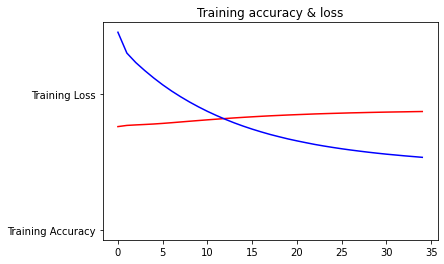

In [ ]:
acc=hist.history['acc']
loss=hist.history['loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, loss, 'b', "Training Loss")
plt.title('Training accuracy & loss')
plt.show()
print("")

# Predictions

In [ ]:
enc_model = Model([enc_inp], enc_states)

decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = dec_lstm(dec_embed, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
dec_model = Model([dec_inp]+ decoder_states_inputs, [decoder_outputs]+ decoder_states)

In [ ]:
# [[32, 45, 65 ,77]] ---> [['hi', 'how', 'are', 'you']] ----> [['hi how are you']] ----> 'hi how are you'
def predict(text):
  text = clean_text(text)                                    # ---------> 'hi how are you'
  text = text.split(' ')                                     # ---------> ['hi', 'how', 'are', 'you']
  temp = []
  for each in text:
    if each in vocab:
      temp.append(vocab.index(each))                         # ---------> vocab = list(vocab_dict.keys())
    else:
      temp.append(vocab.index('<OUT>'))
  text = [temp]                                              # ---------> [[32, 45, 65 ,77]]
  text = pad_sequences(text, padding='post', maxlen=maxi)    # ---------> [[32, 45, 65 ,77, 0, 0,0,.....,0]]
  enc_model = Model([enc_inp], enc_states)
  enc_pred = enc_model.predict(text)                         # ---------> return h,c after running LSTM. Shape: (400) each

  empty_target_seq = np.zeros((1, 1))                        # ---------> [[0]] 2D list
  empty_target_seq[0, 0] = vocab.index('<START>')            # ---------> index of 'start' so that model know it's time to predict 
  
  stop = False
  decoded_translation = ''

  while not stop:
    dec_outputs , h, c= dec_model.predict([empty_target_seq] + enc_pred )       # ---------> takes h,c with 'start' sequence as input
    decoder_concat_input = dense(dec_outputs)                                   # ---------> shape is of vocab with softmax probab (1,1,13015)
    sampled_word_index = np.argmax(decoder_concat_input[0, -1, :])              # ---------> reshapes into (13015,) and argmax

    sampled_word = vocab[sampled_word_index] + ' '
    if sampled_word != '<END> ':
      decoded_translation += sampled_word
    if sampled_word == '<END> ' or len(decoded_translation.split()) > maxi:
      stop = True

    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = sampled_word_index
    enc_pred = [h,c]

  return decoded_translation

In [ ]:
print("##########################################")
print("#          Welcome to Chatbot            #")
print("##########################################")

while True:
  text = input("You : ")
  if text.lower() == 'quit':
    break
  answer = predict(text)
  print(f'Bot : {answer}')
  print("==============================================")

##########################################
#          Welcome to Chatbot            #
##########################################
You : hi let's watch a movie
Bot : no it is not like this 
You : don't you wanna watch a movie?
Bot : i do not want to talk about it 
You : why not?
Bot : i do not know 
You : you're rude
Bot : i am afraid i do not know how to put it in your ear 
You : i hate you
Bot : you do not know 
You : bye
Bot : bye 
You : quit


# Saving the model

In [ ]:
import pickle

In [ ]:
! mkdir 'Saved'

In [ ]:
with open('Saved/vocab_dict.pickle', 'wb') as handle:
    pickle.dump(vocab_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# save the weights individually
for layer in model.layers:
    weights = layer.get_weights()
    if weights != []:
        np.savez(f'Saved/{layer.name}.npz', weights)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Loading and predicting

In [ ]:
import numpy as np
import pickle
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Flatten , Embedding, Input, LSTM, Dropout
from tensorflow.keras.models import Model
from keras.initializers import Constant

In [ ]:
print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Projects/Chatbot/Saved/vocab_dict.pickle', 'rb') as f:
    vocab_dict = pickle.load(f)

In [ ]:
# load the weights
w_embeddings = np.load('/content/drive/MyDrive/Projects/Chatbot/Saved/embedding.npz', allow_pickle=True)
w_encoder_lstm = np.load('/content/drive/MyDrive/Projects/Chatbot/Saved/encoder_lstm.npz', allow_pickle=True)
w_decoder_lstm = np.load('/content/drive/MyDrive/Projects/Chatbot/Saved/decoder_lstm.npz', allow_pickle=True)
w_dense = np.load('/content/drive/MyDrive/Projects/Chatbot/Saved/dense.npz', allow_pickle=True)

In [ ]:
### PREREQUISITES

maxi = 23
vocab = list(vocab_dict.keys())
vocab_size = len(vocab)
embed_dim = 300

embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for i,word in enumerate(vocab):
  embed_vector=vocab_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector

def clean_text(text):
  text = text.lower()
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r" 'bout", " about", text)
  text = re.sub(r"gonna", "going to", text)
  text = re.sub(r"gotta", "got to", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub("\d+","",text) # remove numbers
  text = re.sub(r"[^\w\s]", "", text) # remove punctuations
  return text

In [ ]:
# input of encoder and decoder
enc_inp = Input(shape=(maxi,))
dec_inp = Input(shape=(maxi,))

# this layer embeds the english word in vector form
embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxi, embeddings_initializer=Constant(embed_matrix))
enc_embed = embed(enc_inp)

# LSTM takes all the words at the same time but processes it one by one. The last _,_,_ is related to its previous state. So only final o/p is enough.
enc_lstm = LSTM(400, return_sequences=True, return_state=True)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c]

# embedding is done in decoding and the LSTM return a series of sequence
dec_embed = embed(dec_inp)
dec_lstm = LSTM(400, return_sequences=True, return_state=True)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

dense = Dense(vocab_size, activation='softmax')
dense_op = dense(dec_op)

load_model = Model([enc_inp, dec_inp], dense_op)
load_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['acc'],optimizer='adam')

In [ ]:
load_model.layers

In [ ]:
# set the weights of the model

load_model.layers[2].set_weights(w_embeddings['arr_0'])
load_model.layers[3].set_weights(w_encoder_lstm['arr_0'])
load_model.layers[4].set_weights(w_decoder_lstm['arr_0'])
load_model.layers[5].set_weights(w_dense['arr_0'])

In [ ]:
enc_model = Model([enc_inp], enc_states)

decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = dec_lstm(dec_embed, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
dec_model = Model([dec_inp]+ decoder_states_inputs, [decoder_outputs]+ decoder_states)

In [ ]:
# [[32, 45, 65 ,77]] ---> [['hi', 'how', 'are', 'you']] ----> [['hi how are you']] ----> 'hi how are you'
def predict(text):
  text = clean_text(text)                                    # ---------> 'hi how are you'
  text = text.split(' ')                                     # ---------> ['hi', 'how', 'are', 'you']
  temp = []
  for each in text:
    if each in vocab:
      temp.append(vocab.index(each))                         # ---------> vocab = list(vocab_dict.keys())
    else:
      temp.append(vocab.index('<OUT>'))
  text = [temp]                                              # ---------> [[32, 45, 65 ,77]]
  text = pad_sequences(text, padding='post', maxlen=maxi)    # ---------> [[32, 45, 65 ,77, 0, 0,0,.....,0]]
  enc_model = Model([enc_inp], enc_states)
  enc_pred = enc_model.predict(text)                         # ---------> return h,c after running LSTM. Shape: (400) each

  empty_target_seq = np.zeros((1, 1))                        # ---------> [[0]] 2D list
  empty_target_seq[0, 0] = vocab.index('<START>')            # ---------> index of 'start' so that model know it's time to predict 
  
  stop = False
  decoded_translation = ''

  while not stop:
    dec_outputs , h, c= dec_model.predict([empty_target_seq] + enc_pred )       # ---------> takes h,c with 'start' sequence as input
    decoder_concat_input = dense(dec_outputs)                                   # ---------> shape is of vocab with softmax probab (1,1,13015)
    sampled_word_index = np.argmax(decoder_concat_input[0, -1, :])              # ---------> reshapes into (13015,) and argmax

    sampled_word = vocab[sampled_word_index] + ' '
    if sampled_word != '<END> ':
      decoded_translation += sampled_word
    if sampled_word == '<END> ' or len(decoded_translation.split()) > maxi:
      stop = True

    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = sampled_word_index
    enc_pred = [h,c]

  return decoded_translation

In [ ]:
print("##########################################")
print("#          Welcome to Chatbot            #")
print("##########################################")

while True:
  text = input("You : ")
  if text.lower() == 'quit':
    break
  answer = predict(text)
  print(f'Bot : {answer}')
  print("==============================================")

##########################################
#          Welcome to Chatbot            #
##########################################
You : hey how are you
Bot : oh i am fine i am fine 
You : and what about mom?
Bot : tell me where the hell do you go from 
You : how is mom?
Bot : fine 
You : and dad?
Bot : he is dead 
You : when?
Bot : when i am free 
You : wanna fight?
Bot : what is it 
You : fight with me
Bot : where is it 
You : at my place
Bot : that is fun 
You : you suck
Bot : what 
You : quit
